# Volatility and Risk

We've seen that the volatility is measured by the average squared deviation from the mean, which is the standard deviation.

Let's read the sample returns that we've been working with.

In [2]:
import pandas as pd
prices = pd.read_csv("../data/sample_prices.csv")
returns = prices.pct_change()
returns

,BLUE,ORANGE
0,NaN,NaN
1,0.023621,0.039662
2,-0.021807,-0.033638
3,-0.031763,0.082232
4,0.034477,0.044544
5,0.037786,-0.026381
6,-0.011452,-0.049187
7,0.032676,0.117008
8,-0.012581,0.067353
9,0.029581,0.078249


Notice that the first set of returns are NaN, which is Pandas way of saying that it's an NA. We can drop that row using the `.dropna()` method.

In [6]:
returns = returns.dropna()
returns

,BLUE,ORANGE
1,0.023621,0.039662
2,-0.021807,-0.033638
3,-0.031763,0.082232
4,0.034477,0.044544
5,0.037786,-0.026381
6,-0.011452,-0.049187
7,0.032676,0.117008
8,-0.012581,0.067353
9,0.029581,0.078249
10,0.006151,-0.168261


In [3]:
import numpy as np
sd = returns.std()
sdn = np.std(returns, ddof=1)
print(sdn, '---', sd)

BLUE      0.023977
ORANGE    0.079601
dtype: float64 --- BLUE      0.023977
ORANGE    0.079601
dtype: float64


/Users/paulhake/Documents/claude_code_class/notebooks_and_codem01_v02/portfolio_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Let's compute the standard deviation from first principals:

In [3]:
deviations = returns - returns.mean()
squared_deviations = deviations**2
mean_squared_deviations = squared_deviations.mean()

import numpy as np

volatility = np.sqrt(mean_squared_deviations)
volatility

BLUE      0.022957
ORANGE    0.076212
dtype: float64

Let's see if we get the same answer when we use the built-in `.std()` method.

In [4]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

Why don't they match? Because, by default, the `.std()` method computes the _sample standard deviation_ which means that it uses the denominator of $n-1$. On the other hand, we computed the _population_ standard deviation, which uses a numerator of $n$. Since the observed returns are thought of as observed samples from a distribution, it is probably more accurate to use the denominator of $n-1$, so let's redo our calculation to see if we get the same number.

To get the number of observations, we can use the `.shape` attribute of a DataFrame that returns a tuple of the number of rows and columns.

In [5]:
returns.shape

(12, 2)

Just as we can with a list, we can access the elements of a tuple using an index, starting at 0. Therefore, to get the number of rows in the DataFrame, we extract the 0th element of the tuple.

In [6]:
number_of_obs = returns.shape[0]
mean_squared_deviations = squared_deviations.sum()/(number_of_obs-1)
volatility = np.sqrt(mean_squared_deviations)
volatility

BLUE      0.023977
ORANGE    0.079601
dtype: float64

In [7]:
returns.std()

BLUE      0.023977
ORANGE    0.079601
dtype: float64

# Annualizing Volatility

We annualize volatility by scaling (multiplying) it by the square root of the number of periods per observation

Therefore, to annualize the volatility of a monthly series, we muiltiply it by the square root of 12. Instead of using the `np.sqrt()` we can raise it to the power of $0.5$

In [8]:
annualized_vol = returns.std()*(12**0.5)
annualized_vol

BLUE      0.083060
ORANGE    0.275747
dtype: float64

# Risk Adjusted Returns

Let's get beyond the sample data series and start working with some real data. Read in the monthly returns of a set of 10 portfolios formed on market caps, or market equities of the companies. Of the 10 portfolios, we only want to look at the largest cap and the smallest cap companies:

In [5]:
me_m = pd.read_csv("../data/Portfolios_Formed_on_ME_monthly_EW.csv",
                   header=0, index_col=0, parse_dates=True, na_values=-99.99)
me_m.head()

/var/folders/qj/0m_9ythn431_06y4v80zxls00000gn/T/ipykernel_68096/4149715836.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  me_m = pd.read_csv("../data/Portfolios_Formed_on_ME_monthly_EW.csv",


,<= 0,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
192607,NaN,-0.43,1.52,2.68,-0.57,0.59,1.60,1.47,3.33,-1.45,0.29,-0.15,1.33,1.24,1.98,1.55,1.38,3.38,3.29
192608,NaN,3.90,3.04,2.09,3.84,3.59,3.71,1.61,2.33,5.12,2.59,4.03,3.15,2.72,4.72,1.60,1.63,0.98,3.70
192609,NaN,-1.08,-0.54,0.16,-0.48,-1.40,0.00,-0.50,-0.09,0.93,-1.87,-2.27,-0.53,0.07,-0.07,-1.64,0.64,-0.86,0.67
192610,NaN,-3.32,-3.52,-3.06,-3.29,-4.10,-2.89,-3.36,-2.95,-4.84,-1.77,-3.36,-4.83,-2.98,-2.80,-3.45,-3.27,-3.47,-2.43
192611,NaN,-0.46,3.82,3.09,-0.55,2.18,3.41,3.39,3.16,-0.78,-0.32,-0.29,4.65,3.24,3.57,3.82,2.95,3.61,2.70


In [6]:
cols = ['Lo 10', 'Hi 10']
returns = me_m[cols]
returns.head()

,Lo 10,Hi 10
192607,-1.45,3.29
192608,5.12,3.70
192609,0.93,0.67
192610,-4.84,-2.43
192611,-0.78,2.70


Note that the data is already given in percentages (i.e 4.5 instead of 0.045) and we typically want to use the actual numbers (i.e. 0.045 instead of 4.5) so we should divide the raw data from the file by 100.

In [7]:
returns = returns/100

<Axes: >

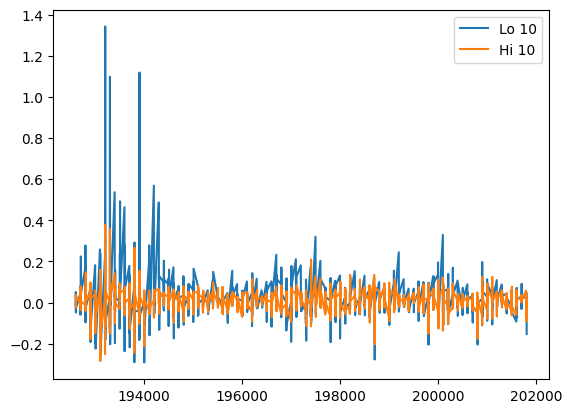

In [8]:
returns.plot()

In [9]:
returns.columns = ['SmallCap', 'LargeCap']

<Axes: >

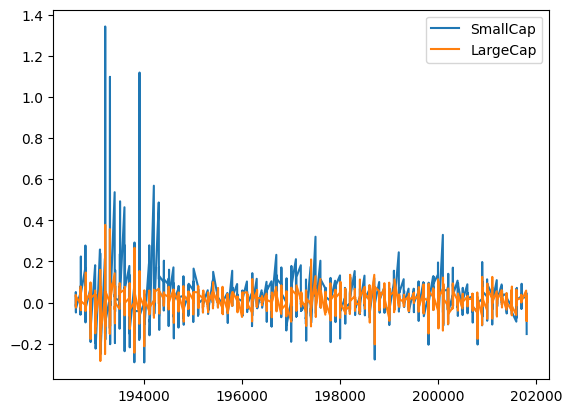

In [10]:
returns.plot()

In [11]:
annualized_vol = returns.std()*np.sqrt(12)
annualized_vol

SmallCap    0.368193
LargeCap    0.186716
dtype: float64

We can now compute the annualized returns as follows:

In [12]:
n_months = returns.shape[0]
return_per_month = (returns+1).prod()**(1/n_months) - 1
return_per_month

SmallCap    0.012986
LargeCap    0.007423
dtype: float64

In [13]:
annualized_return = (return_per_month + 1)**12-1

In [14]:
annualized_return = (returns+1).prod()**(12/n_months) - 1
annualized_return

SmallCap    0.167463
LargeCap    0.092810
dtype: float64

In [15]:
annualized_return/annualized_vol

SmallCap    0.454825
LargeCap    0.497063
dtype: float64

In [16]:
riskfree_rate = 0.03
excess_return = annualized_return - riskfree_rate
sharpe_ratio = excess_return/annualized_vol
sharpe_ratio

SmallCap    0.373346
LargeCap    0.336392
dtype: float64